Imports and constants

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm

import torch
import torch.utils.data as thd
import torch.nn as nn

from sklearn.metrics import fbeta_score, precision_score, recall_score
from scipy.ndimage.filters import gaussian_filter1d

import matplotlib.pyplot as plt
from collections import defaultdict
import os
import gc
from operator import itemgetter
from pympler import tracker

# Ignore SKLearn warnings
import warnings
from sklearn.exceptions import UndefinedMetricWarning
warnings.filterwarnings(action='ignore', category=UndefinedMetricWarning)

BATCH_SIZE = 256
BUFFER = 10  # Buffer size in both dimensions: x and y. Effective patch size is [BUFFER * 2 + 1, BUFFER * 2 + 1, Z_DIM].
SLICES = 65
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 0.3
Z_START = 24
Z_END = 34
Z_STEP = 1
Z_DIM = (Z_END - Z_START) // Z_STEP
TRAIN_ON_FRAGMENTS = [1, 2]
VAL_FRAGMENT = 3
DISABLE_TQDM = False

MAX_TRAIN_STEPS = 1000
MAX_VAL_STEPS = 1000
PRINT_EVERY = 20000000

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


First, let's see if we can fit all one full fragment into memory at once.

In [2]:
def pad_array(array):
    padding = (
        (BUFFER, BUFFER),
        (BUFFER, BUFFER),
    )
    return np.pad(array, padding)

def load_fragment_surface(fragment, split='train'):
    print("Loading fragment %s surface" % fragment)
    surface_path = Path("/kaggle/input/vesuvius-challenge-ink-detection/%s/%s/surface_volume" % (split, fragment))
    return np.array([
        (pad_array(np.array(Image.open(f))) / (2 ** 16)).astype('float16')
        for f in tqdm(sorted(surface_path.rglob("*.tif"))[Z_START:Z_END:Z_STEP], disable=DISABLE_TQDM)
    ])

def load_mask(fragment, split='train'):
    print("Loading fragment %s mask" % fragment)
    mask_path = Path("/kaggle/input/vesuvius-challenge-ink-detection/%s/%s/mask.png" % (split, fragment))
    return pad_array(np.array(Image.open(mask_path)))

def load_inklabels(fragment, split='train'):
    print("Loading fragment %s labels" % fragment)
    inklabels_path = Path("/kaggle/input/vesuvius-challenge-ink-detection/%s/%s/inklabels.png" % (split, fragment))
    return pad_array(np.array(Image.open(inklabels_path)))

In [3]:
class SingleFragmentDataset(thd.Dataset):
    def __init__(self, fragment, split_name='train'):
        assert split_name in ['train', 'val', 'test']
        self.split_name = split_name
        directory = 'test' if split_name == 'test' else 'train'
        self.surface = load_fragment_surface(fragment, directory)
        print(self.surface.dtype)
        self.mask = load_mask(fragment, directory)
        self.inklabels = load_inklabels(fragment, directory) if self.split_name != 'test' else None
        self.pixels = np.stack(np.where(self.mask == 1), axis=1)
    
    def __len__(self):
        return self.pixels.shape[0]
    
    def get_pixel_number(self, y, x):
        return 1 + y * self.surface.shape[2] + x
    
    def __getitem__(self, index):
        y, x = self.pixels[index]
        y_start = y - BUFFER
        y_end = y + BUFFER + 1
        x_start = x - BUFFER
        x_end = x + BUFFER + 1
        patch_surface = np.s_[:, y_start:y_end, x_start:x_end]
        patch_labels = np.s_[y_start:y_end, x_start:x_end]
        surface = self.surface[patch_surface].astype(np.float32)
        labels = self.inklabels[y, x].reshape((1, )).astype(np.float32) if self.split_name != 'test' else None
        pixel_number = self.get_pixel_number(y, x)
        return {
            'train': (surface, labels),
            'val': (surface, labels, pixel_number),
            'test': (surface, pixel_number)
        }[self.split_name]

Define the model

In [4]:
convnet = nn.Sequential(
    nn.Conv2d(Z_DIM, 32, kernel_size=3, stride=1, dilation=1, padding='same'),
    nn.Dropout(p=0.2),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    
    nn.Conv2d(32, 32, kernel_size=3, stride=1, dilation=1, padding='same'),
    nn.Dropout(p=0.2),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    
    nn.Conv2d(32, 32, kernel_size=3, stride=1, dilation=1, padding='same'),
    nn.Dropout(p=0.2),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    
    nn.Conv2d(32, 32, kernel_size=3, stride=1, dilation=1, padding='same'),
    nn.Dropout(p=0.2),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    
    nn.Conv2d(32, 32, kernel_size=3, stride=1, dilation=1, padding='same'),
    nn.Dropout(p=0.2),
    nn.ReLU(),
    nn.BatchNorm2d(32),
    
    nn.Conv2d(32, 1, kernel_size=3, stride=1, dilation=1, padding='same'),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear((2 * BUFFER + 1) ** 2, 128),
    nn.Dropout(p=0.2),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.Dropout(p=0.2),
    nn.ReLU(),
    nn.Linear(64, 1),
    nn.Sigmoid()
).to(DEVICE)

Train the model

Loading fragment 1 surface


  0%|          | 0/10 [00:00<?, ?it/s]

float16
Loading fragment 1 mask
Loading fragment 1 labels
(10, 8201, 6350)
41


/opt/conda/lib/python3.10/site-packages/torch/distributed/distributed_c10d.py:283: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(


[['str', 311500, 50413398], ['dict', 107589, 35235384], ['code', 81170, 14451663], ['type', 11093, 10524560], ['list', 65161, 6559912], ['tuple', 94202, 6002984], ['set', 3813, 2389048], ['collections.OrderedDict', 3109, 1710344], ['weakref.ReferenceType', 18900, 1360800], ['builtin_function_or_method', 16293, 1173096]]


  0%|          | 0/113840 [00:00<?, ?it/s]

Loading fragment 2 surface


  0%|          | 0/10 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/PIL/Image.py:3176: DecompressionBombWarning: Image size (140973980 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


float16
Loading fragment 2 mask
Loading fragment 2 labels
(10, 14850, 9526)
92


/opt/conda/lib/python3.10/site-packages/torch/distributed/distributed_c10d.py:283: UserWarning: torch.distributed.reduce_op is deprecated, please use torch.distributed.ReduceOp instead
  warnings.warn(


[['str', 314746, 50706740], ['dict', 108211, 35419760], ['code', 81172, 14524578], ['type', 11094, 10526832], ['list', 65385, 6613080], ['tuple', 94266, 6006632], ['set', 3847, 2401000], ['collections.OrderedDict', 3109, 1710344], ['weakref.ReferenceType', 19176, 1380672], ['builtin_function_or_method', 16571, 1193112]]


  0%|          | 0/382788 [00:00<?, ?it/s]

CPU times: user 2min 33s, sys: 21.4 s, total: 2min 54s
Wall time: 4min 1s


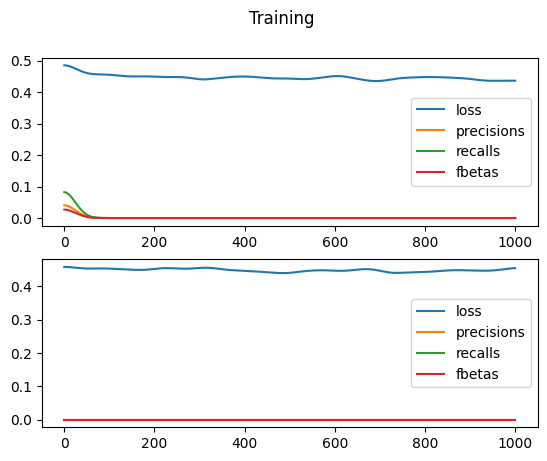

In [5]:
%%time

criterion = nn.BCELoss()

fig, axs = plt.subplots(2)
fig.suptitle('Training')

def train(fragment_number, pltaxs):
    train_dataset = SingleFragmentDataset(fragment_number)
    print(train_dataset.surface.shape)
    train_loader = thd.DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
    
    print(gc.collect())
    mem = tracker.SummaryTracker()
    print(sorted(mem.create_summary(), reverse=True, key=itemgetter(2))[:10])
    
    losses = []
    fbetas = []
    precisions = []
    recalls = []

    convnet.train()
    optimizer = torch.optim.SGD(convnet.parameters(), lr=LEARNING_RATE)
    for i, (xs, ys) in enumerate(pbar := tqdm(train_loader, disable=DISABLE_TQDM)):
        if i > MAX_TRAIN_STEPS:
            break
        optimizer.zero_grad()
        outputs = convnet(xs.to(DEVICE))
        loss = criterion(outputs, ys.to(DEVICE))
        pred_ink = outputs.detach().gt(0.4).cpu().int()
        fbeta = fbeta_score(ys.view(-1).numpy(), pred_ink.view(-1).numpy(), beta=0.5)
        precision = precision_score(ys.view(-1).numpy(), pred_ink.view(-1).numpy())
        recall = recall_score(ys.view(-1).numpy(), pred_ink.view(-1).numpy())
        pbar.set_postfix({"loss": loss, "prec": precision, "rec": recall, "fbeta": fbeta})
        loss.backward()
        optimizer.step()

        fbetas.append(fbeta)
        losses.append(loss.detach().cpu().float())
        precisions.append(precision)
        recalls.append(recall)
    
    del train_loader
    del train_dataset
    gc.collect()
    
    pltaxs.plot(gaussian_filter1d(losses, sigma=25), label='loss')
    pltaxs.plot(gaussian_filter1d(precisions, sigma=25), label='precisions')
    pltaxs.plot(gaussian_filter1d(recalls, sigma=25), label='recalls')
    pltaxs.plot(gaussian_filter1d(fbetas, sigma=25), label='fbetas')
    pltaxs.legend()

for i, fragment_number in enumerate(TRAIN_ON_FRAGMENTS):
    train(fragment_number, axs[i])

Pick the best threshold according to validation set

In [10]:
convnet.eval()
val_dataset = SingleFragmentDataset(VAL_FRAGMENT, split_name='val')
val_loader = thd.DataLoader(val_dataset, BATCH_SIZE, shuffle=True)

def evaluate(threshold):
    print("Evaluating for threshold %f" % threshold)
    losses = []
    accs = []
    fbetas = []
    precisions = []
    recalls = []
    
    img = np.zeros(val_dataset.surface.shape[1:])

    for i, (xs, ys, pixels) in enumerate(pbar := tqdm(val_loader, disable=DISABLE_TQDM)):
        if i > MAX_VAL_STEPS:
            break
        outputs = convnet(xs.to(DEVICE))
        loss = criterion(outputs, ys.to(DEVICE))
        pred_ink = outputs.detach().gt(threshold).cpu().int()
        accuracy = (pred_ink == ys).sum().float().div(ys.size(0))
        fbeta = fbeta_score(ys.view(-1).numpy(), pred_ink.view(-1).numpy(), beta=0.5)
        precision = precision_score(ys.view(-1).numpy(), pred_ink.view(-1).numpy())
        recall = recall_score(ys.view(-1).numpy(), pred_ink.view(-1).numpy())
        pbar.set_postfix({"loss": loss, "acc": accuracy, "fbeta": fbeta})

        fbetas.append(fbeta)
        losses.append(loss.detach().cpu().float())
        accs.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        
        pixels_with_ink = ys[pred_ink == 1].int().tolist()
        for p in pixels_with_ink:
            img[p] = 1
    
    plt.imshow(img)
    plt.show()
    
    return np.mean(losses), np.mean(accs), np.mean(fbetas), np.mean(precisions), np.mean(recalls)


def evaluate_for_thresholds():
    thresholds = [0.1, 0.125, 0.15, 0.175, 0.2, 0.25, 0.325, 0.4]
    
    best_fbeta = 0.
    best_threshold = 0
    
    fbetas = []
    precisions = []
    recalls = []

    for threshold in thresholds:
        _, _, fbeta, precision, recall = evaluate(threshold)
        if fbeta > best_fbeta:
            best_fbeta = fbeta
            best_threshold = threshold
        fbetas.append(fbeta)
        precisions.append(precision)
        recalls.append(recall)
    
    plt.plot(thresholds, fbetas, label="fbeta")
    plt.plot(thresholds, precisions, label="precision")
    plt.plot(thresholds, recalls, label="recall")
    plt.legend()
    
    return best_threshold

best_threshold = evaluate_for_thresholds()
print("Best threshold:", best_threshold)

Loading fragment 3 surface


  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

Validate on full validation set

In [ ]:
MAX_VAL_STEPS = 10**10
evaluate(best_threshold)

Generate test predictions

In [ ]:
# [0, 1, 2, 4, 5]
# [-INF, 0, 1, 2, 4, 5, INF]
# [(0, -INF), (1, 0), (2, 1), (4, 2), (5, 4), (INF, 5)]
# starts: [0, 4, INF]
# ends: [-INF, 2, 5]

def rle(sorted_pixels):
    print("Encoding RLE")
    INF = 10**15
    sorted_pixels = [-INF] + sorted_pixels + [INF]
    zipped = list(zip(sorted_pixels[1:], sorted_pixels[:-1]))
    starts = [p[0] for p in zipped if p[0] != p[1] + 1]
    ends = [p[1] for p in zipped if p[0] != p[1] + 1]
    pairs = [(p[0], p[1] - p[0] + 1) for p in zip(starts[:-1], ends[1:])]
    return ' '.join(list(map(lambda p: "%d %d" % (p[0], p[1]), pairs)))

print(rle([0, 1, 2, 4, 5]))
print(rle([]))
print(rle([1, 3, 5, 7]))
# assert rle([0, 1, 2, 4, 5]) == "0 3 4 2"

In [ ]:
del val_loader
del val_dataset
gc.collect()

submission = defaultdict(list)

for fragment in ['a', 'b']:
    pixels_with_ink = []
    print(f"Generating predictions for fragment {fragment}")
    test_dataset = SingleFragmentDataset(fragment, split_name='test')
    test_loader = thd.DataLoader(test_dataset, BATCH_SIZE, shuffle=True)
    for (xs, ys) in (pbar := tqdm(test_loader, disable=DISABLE_TQDM)):
        outputs = convnet(xs.to(DEVICE))
        pred_ink = outputs.detach().gt(best_threshold).flatten().cpu().int()
        pred_ink = pred_ink[:len(ys)]
        pixels_with_ink += ys[pred_ink == 1].int().tolist()
    pixels_with_ink.sort()
    
    submission["Id"].append(fragment)
    submission["Predicted"].append(rle(pixels_with_ink))
    
pd.DataFrame.from_dict(submission).to_csv("/kaggle/working/submission.csv", index=False)

In [ ]:
pd.DataFrame.from_dict(submission)